Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



Logistic Regression Accuracy:  0.631578947368421

Random Forest Accuracy:  0.631578947368421

SVC Accuracy:  0.5526315789473685

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.62      0.76      0.68        17
           1       0.50      0.22      0.31         9
           2       0.69      0.75      0.72        12

    accuracy                           0.63        38
   macro avg       0.60      0.58      0.57        38
weighted avg       0.61      0.63      0.61        38


Random Forest Report:
               precision    recall  f1-score   support

           0       0.68      0.76      0.72        17
           1       0.33      0.22      0.27         9
           2       0.69      0.75      0.72        12

    accuracy                           0.63        38
   macro avg       0.57      0.58      0.57        38
weighted avg       0.60      0.63      0.61        38


SVC Report:
               precision    recall  f1-sco

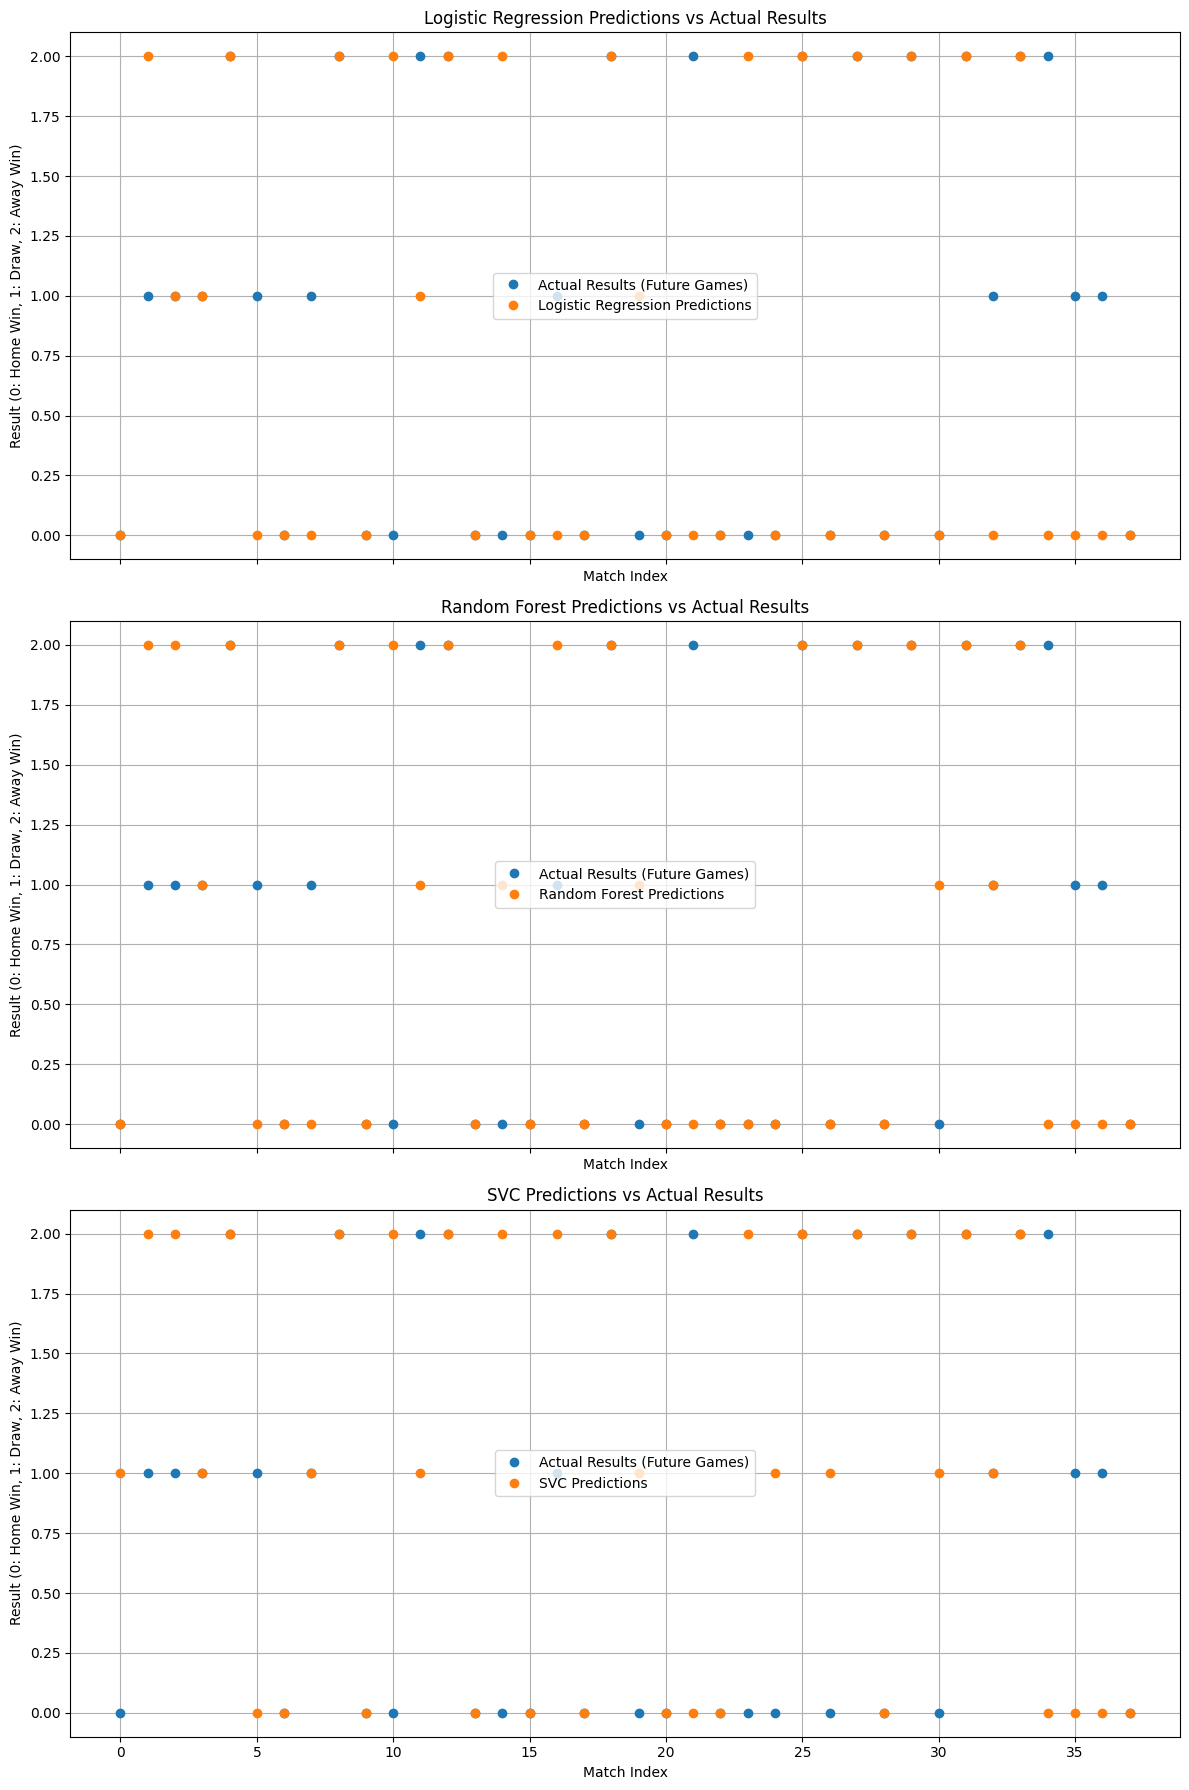

In [15]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC  # Importing SVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Mount Google Drive to access the dataset
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset from the Excel file
file_path = '/content/drive/MyDrive/EPL/final_dataset (10-15).xlsx'
df = pd.read_excel(file_path)

# Function to calculate team form (based on last N matches)
def calculate_form(df, team, is_home=True, n_matches=5):
    form_points = []
    for index, row in df.iterrows():
        if is_home:
            team_matches = df[(df['HomeTeam'] == team) & (df.index < index)].tail(n_matches)
        else:
            team_matches = df[(df['AwayTeam'] == team) & (df.index < index)].tail(n_matches)

        points = 0
        for _, match in team_matches.iterrows():
            if match['HomeTeam'] == team and match['FTR'] == 'H':  # Home win
                points += 3
            elif match['AwayTeam'] == team and match['FTR'] == 'A':  # Away win
                points += 3
            elif match['FTR'] == 'D':  # Draw
                points += 1

        form_points.append(points if points > 0 else 0)  # Ensure non-negative
    return form_points[-1] if form_points else 0  # Return last form value or 0 if no matches

# Function to calculate average goals (scored and conceded) for the last N matches
def calculate_avg_goals(df, team, is_home=True, n_matches=5):
    total_goals_scored = 0
    total_goals_conceded = 0
    count = 0

    for index, row in df.iterrows():
        if is_home:
            team_matches = df[(df['HomeTeam'] == team) & (df.index < index)].tail(n_matches)
            goals_scored = team_matches['FTHG'].sum()
            goals_conceded = team_matches['FTAG'].sum()
        else:
            team_matches = df[(df['AwayTeam'] == team) & (df.index < index)].tail(n_matches)
            goals_scored = team_matches['FTAG'].sum()
            goals_conceded = team_matches['FTHG'].sum()

        # Add to totals
        if len(team_matches) > 0:
            total_goals_scored += goals_scored
            total_goals_conceded += goals_conceded
            count += 1  # Only count if there are matches

    return (total_goals_scored / count) if count > 0 else 0, (total_goals_conceded / count) if count > 0 else 0

# Select the team to filter the dataset: 'Arsenal'
team = 'Arsenal'

# Filter the dataset for the particular team, considering both home and away matches
team_df = df[(df['HomeTeam'] == team) | (df['AwayTeam'] == team)]

# Sort the matches by date
team_df = team_df.sort_values(by='Date')

# Calculate Team Form and Average Goals for both Home and Away teams
team_df['HomeForm'] = team_df['HomeTeam'].apply(lambda x: calculate_form(df, x, is_home=True))
team_df['AwayForm'] = team_df['AwayTeam'].apply(lambda x: calculate_form(df, x, is_home=False))
team_df['AvgHomeGoalsScored'], team_df['AvgHomeGoalsConceded'] = zip(*team_df['HomeTeam'].apply(lambda x: calculate_avg_goals(df, x, is_home=True)))
team_df['AvgAwayGoalsScored'], team_df['AvgAwayGoalsConceded'] = zip(*team_df['AwayTeam'].apply(lambda x: calculate_avg_goals(df, x, is_home=False)))

# Drop columns that are not needed for the model
team_df = team_df.drop(['Date', 'HST', 'AST', 'HTHG', 'HTAG', 'HTR', 'FTHG', 'FTAG'], axis=1)

# Encode categorical features like 'HomeTeam' and 'AwayTeam'
le_team = LabelEncoder()
team_df['HomeTeam'] = le_team.fit_transform(team_df['HomeTeam'])
team_df['AwayTeam'] = le_team.transform(team_df['AwayTeam'])

# Prepare the target variable FTR (0: Home Win, 1: Draw, 2: Away Win)
df['FTR'] = df['FTR'].map({'H': 0, 'D': 1, 'A': 2})  # H = Home Win (0), D = Draw (1), A = Away Win (2)
y = df.loc[team_df.index, 'FTR']  # Extract FTR for Arsenal games as the target

# Define features (X) for the model
X = team_df[['HomeTeam', 'AwayTeam', 'HomeForm', 'AwayForm', 'AvgHomeGoalsScored', 'AvgHomeGoalsConceded', 'AvgAwayGoalsScored', 'AvgAwayGoalsConceded']]

# Split the dataset into first 80% (training) and last 20% (testing) based on sorted matches
split_index = int(0.8 * len(team_df))

X_train = X[:split_index]  # First 80% for training
y_train = y[:split_index]

X_test = X[split_index:]  # Last 20% for testing (future matches)
y_test = y[split_index:]

# Train a Multinomial Logistic Regression model
logreg = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

# Train a Support Vector Classifier (SVC) model (multiclass with balanced class weights)
svc = SVC(random_state=42, decision_function_shape='ovr', class_weight='balanced')  # class_weight='balanced' ensures better handling of minority class (draw)
svc.fit(X_train, y_train)
y_pred_svc = svc.predict(X_test)

# GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
rf = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_  # Get the best model after tuning
y_pred_rf = best_rf.predict(X_test)

# Evaluate the models
print("\nLogistic Regression Accuracy: ", accuracy_score(y_test, y_pred_logreg))
print("\nRandom Forest Accuracy: ", accuracy_score(y_test, y_pred_rf))
print("\nSVC Accuracy: ", accuracy_score(y_test, y_pred_svc))

# Classification report for all models
print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_logreg))
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))
print("\nSVC Report:\n", classification_report(y_test, y_pred_svc))

# Create a DataFrame for actual vs predicted results
results_df = pd.DataFrame({
    'Home Team': le_team.inverse_transform(X_test['HomeTeam']),
    'Away Team': le_team.inverse_transform(X_test['AwayTeam']),
    'Actual Result': y_test,
    'Logistic Regression Prediction': y_pred_logreg,
    'Random Forest Prediction': y_pred_rf,
    'SVC Prediction': y_pred_svc  # Adding SVC predictions
})

# Mapping numeric results to string labels
result_map = {0: 'Home Win', 1: 'Draw', 2: 'Away Win'}

# Apply the mapping to 'Actual Result' and all prediction columns
results_df['Actual Result'] = results_df['Actual Result'].map(result_map)
results_df['Logistic Regression Prediction'] = results_df['Logistic Regression Prediction'].map(result_map)
results_df['Random Forest Prediction'] = results_df['Random Forest Prediction'].map(result_map)
results_df['SVC Prediction'] = results_df['SVC Prediction'].map(result_map)

# Display the updated DataFrame
print(results_df)

# Plotting the predictions in separate line graphs for each model
fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

# Logistic Regression plot
axes[0].plot(y_test.values, 'o', label='Actual Results (Future Games)')
axes[0].plot(y_pred_logreg, 'o', label='Logistic Regression Predictions')
axes[0].set_title("Logistic Regression Predictions vs Actual Results")
axes[0].set_xlabel('Match Index')
axes[0].set_ylabel('Result (0: Home Win, 1: Draw, 2: Away Win)')
axes[0].legend()
axes[0].grid(True)

# Random Forest plot
axes[1].plot(y_test.values, 'o', label='Actual Results (Future Games)')
axes[1].plot(y_pred_rf, 'o', label='Random Forest Predictions')
axes[1].set_title("Random Forest Predictions vs Actual Results")
axes[1].set_xlabel('Match Index')
axes[1].set_ylabel('Result (0: Home Win, 1: Draw, 2: Away Win)')
axes[1].legend()
axes[1].grid(True)

# SVC plot
axes[2].plot(y_test.values, 'o', label='Actual Results (Future Games)')
axes[2].plot(y_pred_svc, 'o', label='SVC Predictions')
axes[2].set_title("SVC Predictions vs Actual Results")
axes[2].set_xlabel('Match Index')
axes[2].set_ylabel('Result (0: Home Win, 1: Draw, 2: Away Win)')
axes[2].legend()
axes[2].grid(True)

# Display all plots
plt.tight_layout()
plt.show()
